# Drug of last resort (DoLR) prediction using multimodal MIMIC-III CareView subset

## Objective

This tutorial aims to predict [drug of last resort] (https://en.wikipedia.org/wiki/Drug_of_last_resort) prescription in ICU stays using clinical notes and electronic health records. Drugs of last resort are prescribed in severe deterioration cases. Our objective is not merely to predict who gets a certain drug. Instead, we see drug as a proxy label for an underlying severe condition or clinical decision. 

## Research question

“Can we learn patterns from electronic health records that resemble the early decision-making process for infection or severe deterioration?”

and more specifically:

"Can we predict with sufficient confidence the administration of vancomycin based on clinical notes and other tabular data from the CareView dataset in order to assist early detection of severe deterioration while waiting for lab results?"

## Why this matters

In this study, we use vancomycin administration as a proxy label to explore whether structured and unstructured data contain early signals of severe infection or deterioration. Our goal is not to recommend antibiotic use, but to model the implicit reasoning behind timely interventions. 

We focus on vancomycin. Vancomicin is not a first-line antibiothic drug. It is used when the situation is serious or deteriorating, especially in ICUs. So vancomycin use may signal clinical deterioration, sepsis suspicion, or risk of complications.

*Benefit:*
* Could be used to alert clinicians if someone is at high risk of needing antibiotics before labs come back.
* May reduce time to treatment in critical care.
* Helps develop evidence-based, explainable models of antibiotic stewardship and empirical prescribing.

## Approach
Develop a deep learning pipeline that integrates contextual embeddings from clinical notes (via ClinicalBERT) with structured patient data (demographics, ICU stay details) to predict whether a patient will receive a drug of last resort—such as vancomycin. 

**Data analysis using deep learning**
Analyze MIMIC-III data by integrating unstructured text with structured variables to predict treatment decisions.

**Multimodal data integration**
Combine ClinicalBERT embeddings (from NOTEEVENTS.csv) with structured features (from ADMISSIONS.csv, ICUSTAYS.csv) into a unified patient representation.

**Predictive modeling**
Build and train a neural network model to predict whether a patient will receive vancomycin, illustrating personalized treatment recommendation.

**Explainability and communication**
Use model explainability methods to interpret the model’s recommendations.

# 1. Setup

In [1]:
!python3.10 -m pip install pandas
!python3.10 -m pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [146]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# BERT model & tokenizer path
BERT_MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"

Using device: cpu


# 2. Data loading and preprocessing

We will load the following files from CareVue subset of MIMIC-III:
- PRESCRIPTIONS.csv: To identify if a patient received vancomycin.
- ADMISSIONS.csv: To gather demographics and admission information.
- ICUSTAYS.csv: To capture ICU-related features.
- NOTEEVENTS.csv: To extract clinical notes (we’ll later focus on discharge summaries).
- PATIENTS.csv: To collect additional patient data.

In [4]:
# Map path to dataset folder
data_path = "../mimic-iii-clinical-database-carevue-subset-1.4/"

# Load the relevant data files
df_admissions = pd.read_csv(data_path + "ADMISSIONS.csv")
df_patients = pd.read_csv(data_path + "PATIENTS.csv")
df_icustays = pd.read_csv(data_path + "ICUSTAYS.csv")
df_notes = pd.read_csv(data_path + "NOTEEVENTS.csv")
df_prescriptions = pd.read_csv(data_path + "PRESCRIPTIONS.csv")

print("PRESCRIPTIONS shape:", df_prescriptions.shape)
print("ADMISSIONS shape:", df_admissions.shape)
print("ICUSTAYS shape:", df_icustays.shape)
print("NOTEEVENTS shape:", df_notes.shape)
print("PATIENTS shape:", df_patients.shape)

/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_26172/4188068225.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv(data_path + "NOTEEVENTS.csv")
/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_26172/4188068225.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prescriptions = pd.read_csv(data_path + "PRESCRIPTIONS.csv")


PRESCRIPTIONS shape: (1435643, 19)
ADMISSIONS shape: (26836, 19)
ICUSTAYS shape: (28391, 12)
NOTEEVENTS shape: (880107, 11)
PATIENTS shape: (23692, 8)


In [109]:
print("Initial row count:", len(df_admissions))

# Merge structured data
df = df_admissions.merge(df_patients, on="subject_id", how="left")
print("After merge with PATIENTS:", len(df))
df = df.merge(df_icustays, on=["subject_id", "hadm_id"], how="left")

Initial row count: 26836
After merge with PATIENTS: 26836


In [110]:
# Convert to datetime with error coercion
df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
print("Missing admittime:", df['admittime'].isna().sum())
print("Missing dob:", df['dob'].isna().sum())

# Drop rows with missing or clearly invalid dates
df = df.dropna(subset=['admittime', 'dob'])
print("After dropping missing dates:", len(df))

# Remove rows with impossible future or negative age
df = df[df['dob'] < df['admittime']]
print("After dob < admittime filter:", len(df))

# Cap admissible dob to avoid overflow (e.g., dob after 1900, admittime before 2200)
valid_range = (df['dob'] > pd.Timestamp('1900-01-01')) & (df['admittime'] < pd.Timestamp('2200-01-01'))
df = df[valid_range].copy()

# Compute age safely
df['age'] = (df['admittime'] - df['dob']).dt.total_seconds() / (60 * 60 * 24 * 365.25)

# Cap age at 89 as per MIMIC policy
df.loc[df['age'] > 89, 'age'] = 89

# Final check
print("Remaining rows:", len(df))
print("Age stats:")
print(df['age'].describe())

Missing admittime: 0
Missing dob: 0
After dropping missing dates: 28391
After dob < admittime filter: 28384
Remaining rows: 26845
Age stats:
count    26845.000000
mean        44.476403
std         32.215498
min          0.000002
25%          0.002411
50%         54.861476
75%         72.795233
max         88.995397
Name: age, dtype: float64


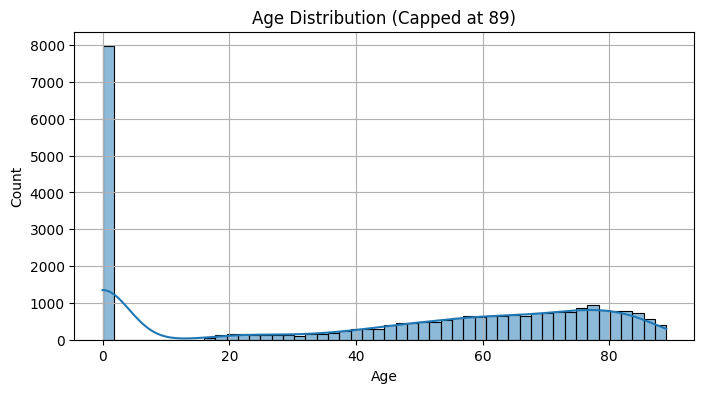

In [111]:
# Visualize age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=50, kde=True)
plt.title("Age Distribution (Capped at 89)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.show()

*The subset includes ~8k newborns*

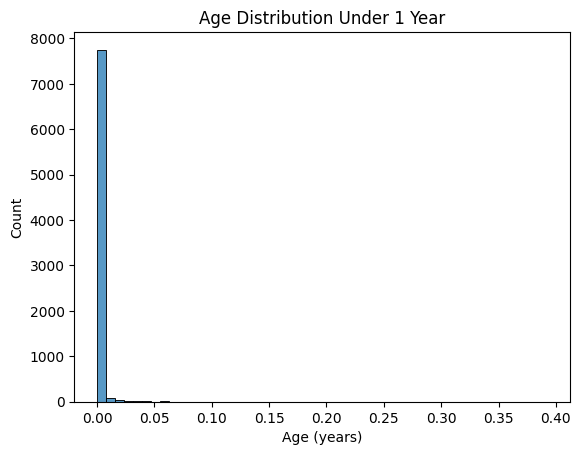

In [112]:
sns.histplot(df[df['age'] < 1]['age'], bins=50)
plt.title("Age Distribution Under 1 Year")
plt.xlabel("Age (years)")
plt.show()

We are aiming to assess severe infection likelihood, which behaves differently in newborns than adults. Vancomycin administration is not last resort with newborns. So we should exclude patients <1 year old. 

In [113]:
# Remove patients < 1 year old
df = df[df['age'] >= 1].copy()
print("Remaining rows:", len(df))

Remaining rows: 18880


Min length of stay: 0.0001388888888888889
Max length of stay: 173.07251157407407


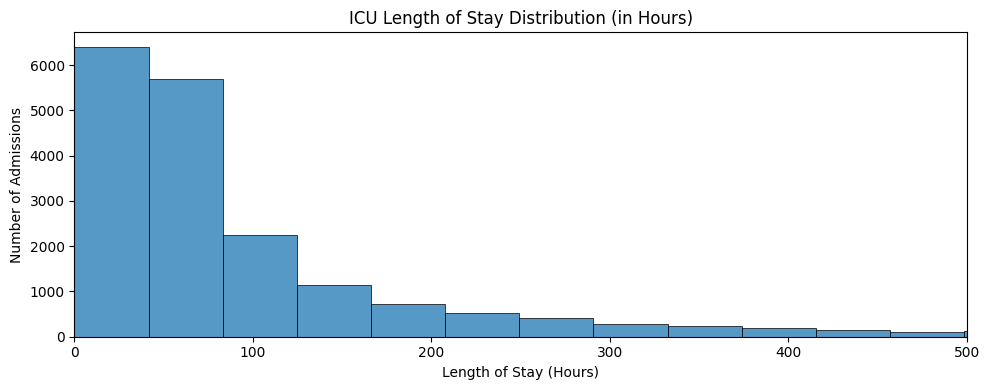

In [114]:
# Calculate ICU Length of Stay (LoS)
if 'intime' in df.columns and 'outtime' in df.columns:
    df['intime'] = pd.to_datetime(df['intime'])
    df['outtime'] = pd.to_datetime(df['outtime'])
    df['los'] = (df['outtime'] - df['intime']).dt.total_seconds() / (3600 * 24)

# Convert LOS to hours for better interpretability
df['los_hours'] = df['los'] * 24  # already in days

print("Min length of stay:",min(df['los']))
print("Max length of stay:",max(df['los']))

plt.figure(figsize=(10, 4))
sns.histplot(df['los_hours'].dropna(), bins=100, kde=False)
plt.title("ICU Length of Stay Distribution (in Hours)")
plt.xlabel("Length of Stay (Hours)")
plt.ylabel("Number of Admissions")
plt.xlim(0, 500)  # optional: clip extreme outliers for readability
plt.tight_layout()
plt.show()

In [115]:
# Add vancomycin flag
df_vanco = df_prescriptions[df_prescriptions['drug'].str.contains("vancomycin", case=False, na=False)]
df['vancomycin_administered'] = df['hadm_id'].isin(df_vanco['hadm_id']).astype(int)
print(df['vancomycin_administered'].value_counts())

vancomycin_administered
0    11221
1     7659
Name: count, dtype: int64


7,659 patients (40.6%) were administered vancomycin (label=1))

In [116]:
# Add structured features
df['is_male'] = (df['gender'] == 'M').astype(int)
df['is_married'] = (df['marital_status'] == 'MARRIED').astype(int)
df['has_medicare'] = (df['insurance'].str.contains("MEDICARE", na=False)).astype(int)
df['is_white'] = (df['ethnicity'].str.upper().str.contains("WHITE")).astype(int)

Total rows: 18880
Missing age: 0
Missing los: 3
Vancomycin counts:
vancomycin_administered
0    11221
1     7659
Name: count, dtype: int64
Age distribution:


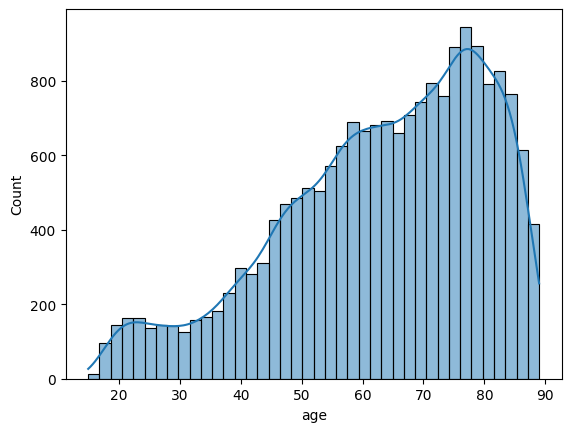

In [117]:
# Verify structured data
print("Total rows:", len(df))
print("Missing age:", df['age'].isna().sum())
print("Missing los:", df['los'].isna().sum())
print("Vancomycin counts:")
print(df['vancomycin_administered'].value_counts())

# Check data
df = df.dropna(subset=['age', 'los'])
print("Age distribution:")
sns.histplot(df['age'], kde=True)
plt.show()

LOS (days) distribution:


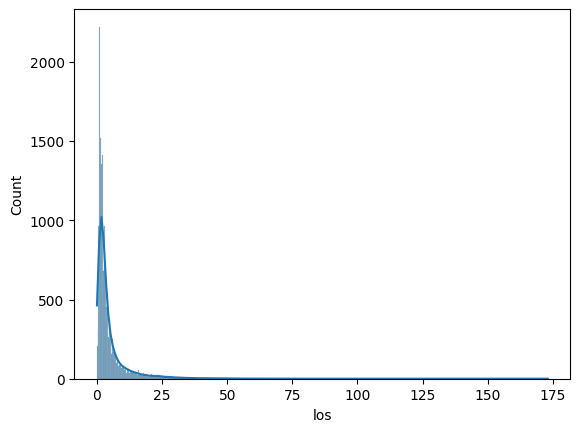

In [118]:
print("LOS (days) distribution:")
sns.histplot(df['los'], kde=True)
plt.show()

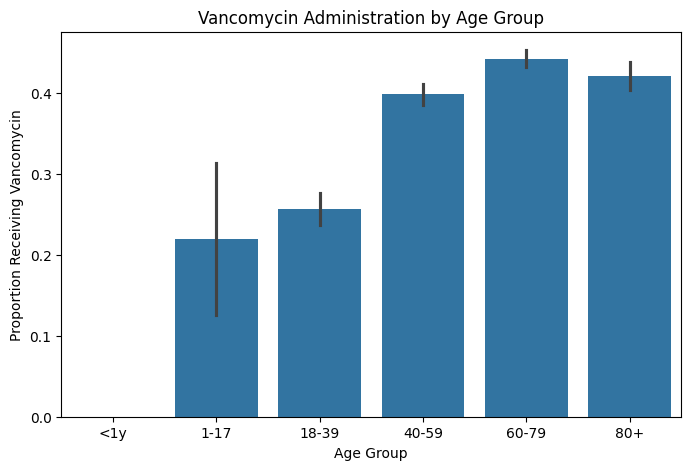

In [119]:
# Define age bins
age_bins = [0, 1, 18, 40, 60, 80, 89]
age_labels = ['<1y', '1-17', '18-39', '40-59', '60-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Plot vancomycin usage by age group
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='age_group', y='vancomycin_administered')
plt.title("Vancomycin Administration by Age Group")
plt.ylabel("Proportion Receiving Vancomycin")
plt.xlabel("Age Group")
plt.show()


*There's a clear increasing trend: older patients are more likely to receive vancomycin. We excluded patients < 1 year and as the diagram shows it was the right decision to focus on severe adult infections.*

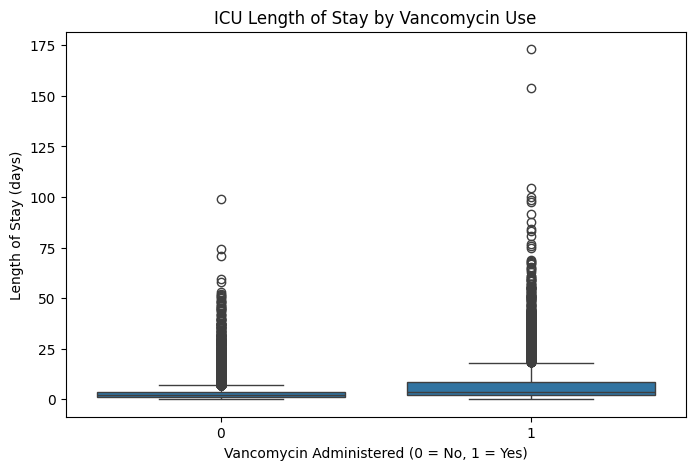

In [120]:
# Plot LOS vs vancomycin use
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='vancomycin_administered', y='los')
plt.title("ICU Length of Stay by Vancomycin Use")
plt.ylabel("Length of Stay (days)")
plt.xlabel("Vancomycin Administered (0 = No, 1 = Yes)")
plt.show()

In [121]:
# Check whether vancomycin administration varies across age groups and length of stay (LOS)

# Statistical summary
print("\nAverage LOS:")
print(df.groupby('vancomycin_administered')['los'].describe())

print("\nVancomycin rate by age group:")
print(df.groupby('age_group')['vancomycin_administered'].mean())


Average LOS:
                           count      mean       std       min       25%  \
vancomycin_administered                                                    
0                        11218.0  3.358949  4.927291  0.000185  1.104343   
1                         7659.0  7.203920  9.584010  0.000139  1.996319   

                              50%       75%         max  
vancomycin_administered                                  
0                        1.941858  3.396910   98.887720  
1                        3.814826  8.468328  173.072512  

Vancomycin rate by age group:
age_group
<1y           NaN
1-17     0.218750
18-39    0.256475
40-59    0.397588
60-79    0.441919
80+      0.420097
Name: vancomycin_administered, dtype: float64


/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_26172/930485522.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('age_group')['vancomycin_administered'].mean())


*Patients receiving vancomycin have a much longer average LOS (7.2 days vs 3.36 days). This suggests that vancomycin use is strongly associated with more severe or complex hospitalizations. Since some of the patients stayed 100s of days in ICU, we're going to add LOS buckets.*

In [122]:
# Define LOS buckets in days
los_bins = [0, 1, 3, 7, 14, 1000]
los_labels = ['<1d', '1-3d', '3-7d', '7-14d', '>14d']
df['los_group'] = pd.cut(df['los'], bins=los_bins, labels=los_labels)

# Sanity checks
print("Vancomycin use by age group:")
print(df.groupby('age_group')['vancomycin_administered'].mean())

print("\nVancomycin use by LOS group:")
print(df.groupby('los_group')['vancomycin_administered'].mean())

Vancomycin use by age group:
age_group
<1y           NaN
1-17     0.218750
18-39    0.256475
40-59    0.397588
60-79    0.441919
80+      0.420097
Name: vancomycin_administered, dtype: float64

Vancomycin use by LOS group:
los_group
<1d      0.207681
1-3d     0.310275
3-7d     0.493020
7-14d    0.645517
>14d     0.737796
Name: vancomycin_administered, dtype: float64


/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_26172/1465155076.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('age_group')['vancomycin_administered'].mean())
/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_26172/1465155076.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('los_group')['vancomycin_administered'].mean())


# 3. Clinical notes aggregation

In [123]:
# Combine notes
notes_grouped = df_notes.groupby("hadm_id")["text"].apply(lambda x: " ".join(x.dropna())).reset_index()
notes_grouped.rename(columns={"text": "combined_notes"}, inplace=True)

In [124]:
# Merge notes with structured data
df_final = pd.merge(df, notes_grouped, on="hadm_id", how="inner")
print("Merged df_final shape:", df_final.shape)
print("Missing notes:", df_final['combined_notes'].isna().sum())

Merged df_final shape: (18711, 46)
Missing notes: 0


# 4. Embedding generation

In [51]:
def get_embeddings_batch(texts, batch_size=32, max_length=512):
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    model = BertModel.from_pretrained(BERT_MODEL_NAME).to(device)
    model.eval()
    
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding Batches"):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(emb)
    return np.vstack(all_embeddings)

In [125]:
# Drop rows with missing notes before embedding
df_final = df_final.dropna(subset=['combined_notes']).copy()
subset_texts = df_final['combined_notes'].tolist()

In [53]:
# Generate embeddings
embeddings = get_embeddings_batch(subset_texts, batch_size=32)
df_final = df_final.reset_index(drop=True)
df_final['bert_embedding'] = list(embeddings)

print("Embeddings generated for:", len(embeddings))

Embedding Batches: 100%|██████████| 585/585 [10:12:06<00:00, 62.78s/it]    


Embeddings generated for: 18714


In [ ]:
#Save embeddings to data folder (just the embeddings w/o tabular data)
embeddings_array = np.array(df_final['bert_embedding'].tolist(), dtype=np.float32)
np.save("bert_embeddings.npy", embeddings_array)

# 5. Feature engineering

In [126]:
#Load precomputed embeddings
embeddings = np.load("bert_embeddings.npy")
df = df.iloc[:len(embeddings)].copy()
df['bert_embedding'] = list(embeddings)
print("Shape of embeddings:", embeddings.shape)

Shape of embeddings: (18714, 768)


In [127]:
# Start from latest cleaned structured+notes merged dataframe
df_notes_grouped = df_notes.groupby("hadm_id")["text"].apply(lambda x: " ".join(x.dropna())).reset_index()
df_notes_grouped.rename(columns={"text": "combined_notes"}, inplace=True)

df_final = df.merge(df_notes_grouped, on="hadm_id", how="inner")

# Ensure same filtering as used during embedding
df_final = df_final.dropna(subset=['combined_notes', 'age', 'los']).copy()

In [128]:
#Trim df_final if too many embeddings
if len(df_final) > len(embeddings):
    df_final = df_final.iloc[:len(embeddings)].copy()
    print(f"Trimmed df_final to match embeddings: {len(df_final)} rows")

#Trim embeddings if too many rows
elif len(embeddings) > len(df_final):
    embeddings = embeddings[:len(df_final)]
    print(f"Trimmed embeddings to match df_final: {embeddings.shape[0]} rows")

Trimmed embeddings to match df_final: 18549 rows


In [129]:
#Perform sanity check
assert len(df_final) == len(embeddings), f"Mismatch: df={len(df_final)}, embeddings={len(embeddings)}"

In [130]:
print("df_final shape:", df_final.shape)
print("embeddings shape:", embeddings.shape)

df_final shape: (18549, 47)
embeddings shape: (18549, 768)


In [131]:
# Reassign the embeddings as a new column
df_final = df_final.reset_index(drop=True)
df_final['bert_embedding'] = list(embeddings)

# Sanity checks
assert 'bert_embedding' in df_final.columns
assert 'age' in df_final.columns
assert 'los' in df_final.columns
assert df_final[['bert_embedding', 'age', 'los']].notna().all().all()

# Confirm embedding length for a few rows
print("First embedding length:", len(df_final['bert_embedding'].iloc[0]))
print("Number of rows with valid embeddings:", df_final['bert_embedding'].notna().sum())

First embedding length: 768
Number of rows with valid embeddings: 18549


In [ ]:
# Create feature vectors by combining embedding with tabular data
def create_feature_vector(row):
    emb = row['bert_embedding']
    structured = np.array([row['age'], row['los'], row['is_male'], row['is_married'], row['has_medicare'], row['is_white']], dtype=np.float32)
    return np.concatenate([emb, structured])

# Apply the function across rows
X = np.stack(df_final.apply(create_feature_vector, axis=1))
y = df_final['vancomycin_administered'].values

# Sanity check
print("Feature matrix shape (X):", X.shape)
print("Target vector shape (y):", y.shape)

Feature matrix shape (X): (18549, 774)
Target vector shape (y): (18549,)


# 6. Model training

In [133]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [134]:
# Define model
model = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,425 (904.00 KB)

 Trainable params: 231,425 (904.00 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
# Compute class weights
weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights_array))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.8437002501705708, 1: 1.2273779983457402}


In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    #stop training if validation loss doesn't improve after 3 consecutive epochs
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)] 
)

Epoch 1/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6443 - loss: 0.6390 - val_accuracy: 0.6705 - val_loss: 0.6237
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6552 - loss: 0.6340 - val_accuracy: 0.6523 - val_loss: 0.6362
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6457 - loss: 0.6373 - val_accuracy: 0.6617 - val_loss: 0.6257
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6542 - loss: 0.6339 - val_accuracy: 0.6705 - val_loss: 0.6231
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6547 - loss: 0.6379 - val_accuracy: 0.6584 - val_loss: 0.6262
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6452 - loss: 0.6413 - val_accuracy: 0.6658 - val_loss: 0.6274
Epoch 7/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6462 - loss: 0.6398 - val_accuracy: 0.6530 - val_loss: 0.6336


# 7. Model evaluation

In [141]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6751 - loss: 0.6179
Test Accuracy: 67.71%


In [142]:
# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.69      0.84      0.75      2199
           1       0.65      0.45      0.53      1511

    accuracy                           0.68      3710
   macro avg       0.67      0.64      0.64      3710
weighted avg       0.67      0.68      0.66      3710



## Analysis
* The model performs reasonably well on predicting non-vancomycin cases (class 0) i.e.,predicting when not to administer drug of last resort.
* Overall accuracy of ~68% shows room for improvement for a complex, noisy clinical prediction task.
* The recall for class 1 (vancomycin) is only 0.45, meaning the model misses over half of true positives.
* This is critical because vancomycin is a drug of last resort—missing these cases might mean patients who need it don't get flagged.

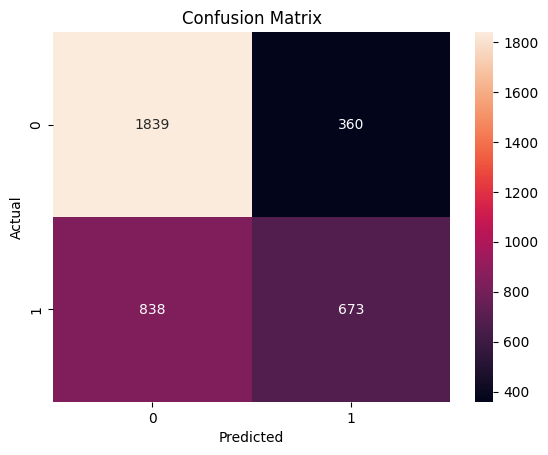

In [143]:
# Confusion matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


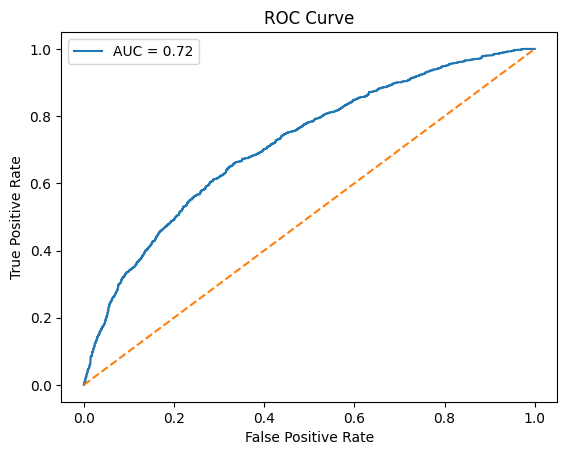

In [144]:
# ROC Curve
probs = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8. Comparison to classical models 

Let's compare our neural network performance against classic models such as linear regression and random forrest.

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


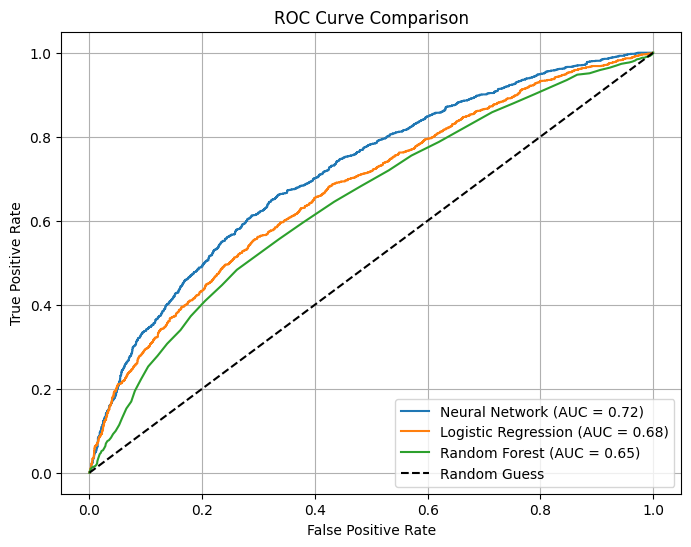

In [147]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
auc_lr = roc_auc_score(y_test, lr_probs)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

# Neural Network
nn_probs = model.predict(X_test).ravel()
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
auc_nn = roc_auc_score(y_test, nn_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Analysis

* Our neural network (with ClinicalBERT embeddings + structured features) outperforms classical models, particularly for overall F1 and recall on the minority class (vancomycin = 1), which is crucial for identifying patients who need vancomycin.

* Logistic regression did surprisingly well. It achieved balanced precision/recall, meaning even with just a linear separator, the structured + BERT features are informative.

* Random Forest is overfitting to the majority class (class 0). High recall for class 0, but poor recall (25%) for class 1 makes it less useful for detecting vancomycin use.

# 9. Summary and conclusion

Achievements
* Used deep learning (BERT + tabular) on MIMIC III CareView dataset
* Built a binary classification tutorial with evaluation
* Multimodal = structured features + embeddings from clinical notes
* Reported class imbalance and used mitigation

Findings
* Deep network outperforms classical approaches
* Better at predicting class 0 than class 1 i.e., predicting when not to administer drug of last resort.
* Overall accuracy of ~68% shows room for improvement for a complex, noisy clinical prediction task.
* Weak signal in features likely area of further investigation. 
